In [118]:
import pandas as pd
import numpy as np
import random
import math
import itertools
import warnings
import pickle
import gc
import sys
import matplotlib.pyplot as plt
from os.path import join, isfile
from collections import Counter
from scipy.special import gamma

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.2f}".format(x)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
mainPath = "../../data"
beacons = join(mainPath, "beacon")
ceuPath = join(beacons, "CEU")

### Step 1: Load Beacon, MAF, Reference and other cached variables

In [3]:
# CEU
beacon = pd.read_csv(join(ceuPath, "Beacon_164.txt"), index_col=0, delim_whitespace=True)
maf = pd.read_csv(join(ceuPath, "MAF.txt"), index_col=0, delim_whitespace=True)
reference = pickle.load(open(join(ceuPath, "reference.pickle"),"rb"))

In [4]:
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)

beacon_people = np.arange(65)
other_people = np.arange(99)+65
all_people = np.arange(164)

In [5]:
# Construct beacons and the victim
shuffled = np.random.permutation(all_people)

victim_ind = shuffled[0]
a_cind = shuffled[1:21]
s_cind = shuffled[21:41]

s_ind = shuffled[41:101]

s_beacon = binary[:, np.concatenate([s_ind,np.array([victim_ind])])]
#s_beacon = binary[:, s_ind]

a_control = binary[:, a_cind]
s_control = binary[:, s_cind]

victim = binary[:, victim_ind]

### Step 2: Function definitions

###### SB LRT

In [6]:
# n: Num query
a=1.6483
b=2.2876
error=0.001

def calculate_sb_delta(num_people, response, n):
    DN = gamma(a + b) / (gamma(b) * (2*num_people + a + b)**a)
    DN_1 = gamma(a + b) / (gamma(b) * (2*(num_people-1) + a + b)**a)
    
    B = np.log(DN / (DN_1 * error)) 
    C = np.log((error * DN_1 * (1 - DN)) / (DN*(1-error*DN_1)))
    return n*B + C*response

def sb_lrt(victim, control_people, beacon, A, S, num_query):
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    
    response = beacon[A].any(axis=1)*S    
    
    # Delta
    delta = calculate_sb_delta(beacon_size, response, num_query)
    
    # Victim delta
    victim_delta = np.sum(np.dot(delta, victim[A]))
    
    # Control delta
    control_delta = np.dot(delta, control_people[A])

    return victim_delta, control_delta

###### Optimal LRT

In [7]:
# n: Num query

def calculate_optimal_delta(num_people, response, n, maf):
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    log1 = np.log(DN_i/(error*DN_i_1))
    log2 = np.log((error*DN_i_1 * (1-DN_i)) / (DN_i * (1-error*DN_i_1)))

    return log1 + log2*response

def optimal_lrt(victim, control_people, beacon, A, S, num_query):
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    
    response = beacon[A].any(axis=1)*S    
    maf_i = maf.iloc[A]["maf"].values + 1e-6
    
    # Delta
    delta = calculate_optimal_delta(beacon_size, response, num_query, maf_i)

    # Victim delta   
    victim_delta = np.sum(np.dot(delta, victim[A]))
    
    # Control delta
    control_delta = np.dot(delta, control_people[A])
    
    return victim_delta, control_delta

###### p-value Function

In [8]:
def p_value(victim_delta, control_delta):
    return np.sum(control_delta <= victim_delta) / control_delta.shape[0]

#### Attacker Utility

In [119]:
def utility_attacker(ai, si, p_prev, p_current, num_query, hps):
    # Gain-Loss=Utility
    a_gain = hps[0]*-np.log(maf.iloc[ai]["maf"]+1e-6)/abs(np.log(1e-6)) + hps[1]*(p_prev - p_current)
    a_loss = hps[2]*(1-si) + hps[3]*num_query/100
    return a_gain-a_loss

In [120]:
def utility_sharer(ai, si, p_prevs, p_currents, hps):
    # Gain-Loss=Utility
    s_gain = hps[2]*(1-si) 
    s_loss = hps[0]*-np.log(maf.iloc[ai]["maf"]+1e-6)/abs(np.log(1e-6))
    + hps[1]*np.sum(p_prevs - p_currents)/len(p_prevs)
    + hps[3]*np.sum(p_currents <= 0.05)/len(p_currents)
    return s_gain-s_loss

In [121]:
# Game scenario
num_query = 100
A = np.random.choice(beacon.shape[0], num_query)
S = np.ones(num_query)
hps = np.random.uniform(low=0.9, high=1, size=(6,))

### Attacker

victim_delta, control_delta = optimal_lrt(victim, a_control, s_beacon, A, S, num_query)
p_victim = p_value(victim_delta, control_delta)
print("Victim's p-value: ",p_victim)    
print("Victim delta: ", victim_delta)
print("Control delta: ", control_delta)

### Sharer

p_donors = np.zeros(s_beacon.shape[1])
for i in range(s_beacon.shape[1]):
    victim_delta, control_delta = optimal_lrt(s_beacon[:, i], s_control, s_beacon, A, S, num_query)
    p_donors[i] = p_value(victim_delta, control_delta)
print("Donors' p-values:\n",p_donors)

Victim's p-value:  0.8
Victim delta:  -4.0942186831927074e-06
Control delta:  [-0.00 -0.18 -0.01 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00
 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.05]
Donors' p-values:
 [0.65 0.10 0.45 0.10 0.30 0.55 0.30 0.40 0.30 0.00 0.65 0.65 0.30 0.10
 0.10 0.65 0.30 0.65 0.60 0.60 0.65 0.30 0.30 0.95 0.95 1.00 0.30 0.65
 0.65 0.30 0.30 0.30 0.45 0.00 0.45 0.30 0.30 0.45 0.30 0.95 0.75 0.30
 0.45 0.75 0.10 0.30 0.60 0.65 0.00 0.30 0.65 0.30 0.95 0.75 0.95 0.65
 0.45 0.65 0.85 0.30 0.45]


###### Random Sequence

In [34]:
# Game scenario
num_query = 20
A = np.random.choice(beacon.shape[0], num_query)
S = np.random.uniform(low=0.95, high=1, size=(num_query,))
S = np.ones(num_query)
hps = np.random.uniform(low=0.9, high=1, size=(6,))
print(victim[A])
print(a_control[A])

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0]
 [1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1]
 [1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1]]


##### Victim SNP instances

In [12]:
in_victim = maf.iloc[np.where(victim)].sort_values("maf")
out_victim = maf.iloc[np.where(1-victim)].sort_values("maf")

_rarest_yes = in_victim.iloc[0:100].index.values
_rarest_no  = out_victim.iloc[0:100].index.values

_common_yes = in_victim.iloc[-100:].index.values
_common_no  = out_victim.iloc[-100:].index.values

_mid_yes = in_victim.iloc[len(in_victim)//2:len(in_victim)//2+100].index.values
_mid_no  = out_victim.iloc[len(out_victim)//2:len(out_victim)//2+100].index.values

_common_control = np.where(np.logical_and(np.any(a_control == 1,axis=1), victim == 1))[0]

###### Rare-Mid-Common

In [66]:
num_query = 23
A = np.concatenate([_rarest_yes[:3], _mid_no[80:100]])
S = np.random.uniform(low=0.95, high=1, size=(num_query,))
hps = 100*np.random.uniform(low=0.9, high=1, size=(6,))
print(victim[A[6]])
print(a_control[A[6]])

0
[0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


###### Common

In [126]:
num_query = 15
A = np.concatenate([_common_control[:5], _common_no[:10]])
S = np.ones(num_query)
#S = np.random.uniform(low=0.95, high=1, size=(num_query,))
hps = 100*np.random.uniform(low=0.9, high=1, size=(6,))
print(victim[A])
print(a_control[A])

[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[[1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0]
 [1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0]
 [1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1]
 [1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1]
 [1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1]
 [1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1]
 [1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1]
 [0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1]
 [0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0]
 [0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0]
 [0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0]]


#### Example

In [127]:
# Attacker Utility
attacker_utility = np.zeros(num_query)

# Previous p-value
p_victim_prev = 1

for i in range(num_query):
    print("QUERY ", i+1)
    print("---------")
    # Current p-value
    victim_delta, control_delta = optimal_lrt(victim, a_control, s_beacon, A[:i+1], S[:i+1], i+1)
    print("Victim delta: ", victim_delta)
    print("Control delta: ", control_delta)
    p_victim_current = p_value(victim_delta, control_delta)
    
    # Gain-Loss=Utility
    attacker_utility[i] = utility_attacker(A[i], S[i], p_victim_prev, p_victim_current, i+1, hps)

    print("U_A(",i+1,"): ", round(attacker_utility[i], 3), "\tP-prev-P-cur: ",p_victim_prev,"-",p_victim_current, "\tMAF: ", maf.iloc[A[i]]["maf"])
    print()

    p_victim_prev = p_victim_current

# Sharer Utility
sharer_utility = np.zeros(num_query)

# Previous p-value
p_donors_prev = np.ones(s_beacon.shape[1])

for i in range(num_query):
    print("QUERY ", i+1)
    print("---------")
    # Current p-value
    p_donors_current = np.zeros(s_beacon.shape[1])

    for j in range(s_beacon.shape[1]):
        victim_delta, control_delta = optimal_lrt(s_beacon[:, j], s_control, s_beacon, A[:i+1], S[:i+1], i+1)
        p_donors_current[j] = p_value(victim_delta, control_delta)
    
    sharer_utility[i] =  utility_sharer(A[i], S[i], p_donors_prev, p_donors_current, hps)
    print("U_S(",i+1,"): ", round(sharer_utility[i], 3), "\tPrev-Cur: ",round(np.sum(p_donors_prev),2),"-",round(np.sum(p_donors_current),2), "\tMAF: ", maf.iloc[A[i]]["maf"])
    print(p_donors_current)
    p_donors_prev = p_donors_current

QUERY  1
---------
Victim delta:  0.0
Control delta:  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00]
U_A( 1 ):  3.981 	P-prev-P-cur:  1 - 1.0 	MAF:  0.482

QUERY  2
---------
Victim delta:  0.0
Control delta:  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00]
U_A( 2 ):  3.499 	P-prev-P-cur:  1.0 - 1.0 	MAF:  0.447

QUERY  3
---------
Victim delta:  -5.52559287214649e-08
Control delta:  [0.00 0.00 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.00 -0.00 -0.00 -0.00 0.00
 0.00 0.00 -0.00 0.00 0.00 0.00 0.00]
U_A( 3 ):  73.431 	P-prev-P-cur:  1.0 - 0.35 	MAF:  0.128

QUERY  4
---------
Victim delta:  -5.52559287214649e-08
Control delta:  [0.00 0.00 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.00 -0.00 -0.00 -0.00 0.00
 0.00 0.00 -0.00 0.00 0.00 0.00 0.00]
U_A( 4 ):  1.311 	P-prev-P-cur:  0.35 - 0.35 	MAF:  0.46

QUERY  5
---------
Victim delta:  -5.52559287214649e-08
Control delta:  [0.00 0.00 0.00 0.00 

U_S( 13 ):  -4.727 	Prev-Cur:  48.2 - 48.2 	MAF:  0.5
[1.00 0.20 1.00 1.00 0.20 1.00 1.00 1.00 0.20 1.00 1.00 1.00 1.00 1.00
 1.00 0.20 1.00 1.00 1.00 0.20 1.00 0.20 0.20 1.00 1.00 1.00 1.00 1.00
 0.20 0.20 1.00 0.20 1.00 1.00 1.00 0.20 1.00 0.20 1.00 0.20 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.20 1.00 1.00 1.00 0.20
 1.00 1.00 1.00 1.00 0.20]
QUERY  14
---------
U_S( 14 ):  -4.727 	Prev-Cur:  48.2 - 48.2 	MAF:  0.5
[1.00 0.20 1.00 1.00 0.20 1.00 1.00 1.00 0.20 1.00 1.00 1.00 1.00 1.00
 1.00 0.20 1.00 1.00 1.00 0.20 1.00 0.20 0.20 1.00 1.00 1.00 1.00 1.00
 0.20 0.20 1.00 0.20 1.00 1.00 1.00 0.20 1.00 0.20 1.00 0.20 1.00 1.00
 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.20 1.00 1.00 1.00 0.20
 1.00 1.00 1.00 1.00 0.20]
QUERY  15
---------
U_S( 15 ):  -4.727 	Prev-Cur:  48.2 - 48.2 	MAF:  0.5
[1.00 0.20 1.00 1.00 0.20 1.00 1.00 1.00 0.20 1.00 1.00 1.00 1.00 1.00
 1.00 0.20 1.00 1.00 1.00 0.20 1.00 0.20 0.20 1.00 1.00 1.00 1.00 1.00
 0.20 0.20 1.00 0.20 1.00 1.00 1.0

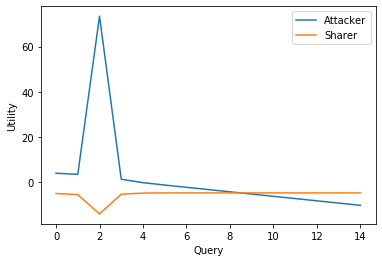

In [128]:
plt.plot(attacker_utility, label="Attacker")
plt.plot(sharer_utility, label="Sharer")
plt.xlabel("Query")
plt.ylabel("Utility")
plt.legend()

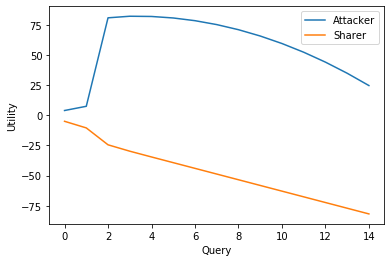

In [129]:
plt.plot(np.cumsum(attacker_utility), label="Attacker")
plt.plot(np.cumsum(sharer_utility), label="Sharer")
plt.xlabel("Query")
plt.ylabel("Utility")
plt.legend()

###### Optimization Trials

In [ ]:
for i in range(num_query):
    print("QUERY ", i+1)
    print("---------")
    # Current p-value
    victim_delta, control_delta = optimal_lrt(victim, a_control, s_beacon, A[:i+1], S[:i+1], i+1)
    print("Victim delta: ", victim_delta)
    print("Control delta: ", control_delta)
    p_victim_current = p_value(victim_delta, control_delta)
    
    # Gain-Loss=Utility
    attacker_utility[i] = utility_attacker(A[i], S[i], p_victim_prev, p_victim_current, hps)

    print("U_A(",i+1,"): ", round(attacker_utility[i], 3), "\tP-prev-P-cur: ",p_victim_prev,"-",p_victim_current, "\tMAF: ", maf.iloc[A[i]]["maf"])
    print()

    p_victim_prev = p_victim_current

# Sharer Utility
sharer_utility = np.zeros(num_query)

# Previous p-value
p_donors_prev = np.ones(s_beacon.shape[1])

for i in range(num_query):
    print("QUERY ", i+1)
    print("---------")
    # Current p-value
    p_donors_current = np.zeros(s_beacon.shape[1])

    for j in range(s_beacon.shape[1]):
        victim_delta, control_delta = optimal_lrt(s_beacon[:, j], s_control, s_beacon, A[:i+1], S[:i+1], i+1)
        p_donors_current[j] = p_value(victim_delta, control_delta)
    
    sharer_utility[i] =  utility_sharer(A[i], S[i], p_donors_prev, p_donors_current, hps)
    print("U_S(",i+1,"): ", round(sharer_utility[i], 3), "\tPrev-Cur: ",round(np.sum(p_donors_prev),2),"-",round(np.sum(p_donors_current),2), "\tMAF: ", maf.iloc[A[i]]["maf"])
    print()
    p_donors_prev = p_donors_current

In [ ]:
# Game scenario
num_query = 40
rares = maf.iloc[np.where(victim)].sort_values("maf").iloc[0:1].index.values
A = np.random.choice(beacon.shape[0], num_query)
A[:len(rares)] = rares
S = np.random.uniform(low=0.95, high=1, size=(num_query,))
S = np.ones(num_query)
hps = np.random.uniform(low=0.9, high=1, size=(6,))
print(victim[A])
print(a_control[A])

In [ ]:
rares = maf.iloc[np.where(victim)].sort_values("maf").iloc[0:1].index.values
rares

# STASH

In [ ]:
'''
#ternary = binary.copy()
#ternary[beacon.values=="NN"] = -1

def lrt_calculate(victim, control_people, beacon, ai, si, num_query):
    victim_delta = 0
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    control_delta = np.zeros(control_size)

    for i in range(num_query):
        # Query the beacon
        response = beacon[ai[i]].any(axis=0)*si[i]

        # Victim delta
        victim_delta += calculate_sb_delta(beacon_size, response, 1) * victim[ai[i]]

        # Control delta
        control_delta += calculate_sb_delta(beacon_size, response, 1) * control_people[ai[i]]

    return victim_delta, control_delta
    
    
victim_delta = 0
a_control_delta = np.zeros(60)

for i in range(num_query):
    # Query the beacon
    response = s_beacon[ai[i]].any(axis=0)#*si[i]
    
    # Victim delta
    victim_delta += calculate_sb_delta(60, response, 1) * victim[ai[i]]
    
    # Control delta
    a_control_delta += calculate_sb_delta(60, response, 1) * a_control[ai[i]]
    #print(victim_delta, "-->", a_control_delta)
    
    # p-value of the victim
    p_victim = np.sum(a_control_delta <= victim_delta) / 60
    print(p_victim) 
'''